# ***화승***

## ***IMPORT LIBRARY***
---

In [79]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [80]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster1"
p_codes = cluster_dict['cluster1']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
# log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Recipe Origin 
recipe_origin_df = recipe_df.copy()

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


In [148]:
log_df

,시간,제품코드,b/t,작업지시번호,전력,전력량,Ram 압력,Rotor speed,mix온도,mix시간,mix 오일투입시간,mix main 압력,카본홀딩호퍼,카본계량호퍼,필러홀딩호퍼,필러계량호퍼,오일홀딩호퍼,오일계량호퍼,대량홀딩호퍼,대량계량호퍼,폴리머계량CV,카본CT-2LEVEL,중량체크,26인치roll중량체크,body옫도,Head bulk 압력,head bulk 온도,rotor 설정속도,rotor 실적속도,rotor 전력,TRF 설정 속도,TRF 실적속도,TRF Bulk 온도,TRF 전력,TRF 압력,자동운전중,작업지시번호-배치
0,2022-01-01 00:00:00,HCSED40011,6.0,211230HCSED400110184,0.0,0.435309,0.011574,0.0,21.0,0.0,25.0,-0.014418,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.274883,NaN,211230HCSED400110184-6
1,2022-01-01 00:00:10,HCSED40011,6.0,211230HCSED400110184,0.0,0.435431,0.008681,0.0,21.0,0.0,25.0,-0.014534,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.74,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.202545,NaN,211230HCSED400110184-6
2,2022-01-01 00:00:20,HCSED40011,6.0,211230HCSED400110184,0.0,0.435475,0.008681,0.0,21.0,0.0,25.0,-0.014496,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.202545,NaN,211230HCSED400110184-6
3,2022-01-01 00:00:30,HCSED40011,6.0,211230HCSED400110184,0.0,0.435557,0.011574,0.0,21.0,0.0,25.0,-0.014367,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.274883,NaN,211230HCSED400110184-6
4,2022-01-01 00:00:40,HCSED40011,6.0,211230HCSED400110184,0.0,0.435685,0.008681,0.0,21.0,0.0,25.0,-0.014487,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.274883,NaN,211230HCSED400110184-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478076,2024-12-31 23:59:20,FFHED70147,17.0,250101FFHED701470129,0.0,0.396512,0.008681,0.0,23.0,0.0,30.0,6.457631,-5.40,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.65559,-0.028,0.000,16.9,14.63396,13.29,160.0,0.0,0.0,2.0,0.0,2.09,0.0,0.274883,NaN,250101FFHED701470129-17
9478077,2024-12-31 23:59:30,FFHED70147,17.0,250101FFHED701470129,0.0,0.396512,0.008681,0.0,23.0,0.0,30.0,6.457631,-5.38,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.59424,-0.028,0.000,16.9,14.63396,13.18,160.0,0.0,0.0,2.0,0.0,1.98,0.0,0.274883,NaN,250101FFHED701470129-17
9478078,2024-12-31 23:59:40,FFHED70147,17.0,250101FFHED701470129,0.0,0.396701,0.011574,0.0,23.0,0.0,30.0,6.457631,-5.38,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.59424,-0.028,0.000,17.0,14.63396,13.29,160.0,0.0,0.0,2.0,0.0,1.98,0.0,0.274883,NaN,250101FFHED701470129-17
9478079,2024-12-31 23:59:50,FFHED70147,17.0,250101FFHED701470129,0.0,0.396763,0.011574,0.0,23.0,0.0,30.0,6.457631,-5.38,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.59424,-0.028,0.000,17.0,14.63396,13.29,160.0,0.0,0.0,2.0,0.0,1.92,0.0,0.274883,NaN,250101FFHED701470129-17


## ***Data Preprocessing***
---

In [81]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [90]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 17)


In [93]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [94]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 38)


In [143]:
### Cluster label 생성 
clst = {1: ['FFWED70267', 'FFWED70033'],
        2: ['FFWED70007', 'FFWED70103'],
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])
dataset = df3.drop(columns=['cluster']).reset_index(drop=True).copy()  
dataset = df3.copy()

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (128985, 39)


In [127]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B 점도 (ML)_결과", "M/B 점도 (MS)_결과",
    "Scorch (T3)_결과", "Scorch (T5)_결과", "Vm (T3)_결과", "Vm (T5)_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time        128226
Ct 90_결과           59585
M/B 점도 (ML)_결과     10171
M/B 점도 (MS)_결과       759
Scorch (T3)_결과       756
Scorch (T5)_결과     14498
Vm (T3)_결과         24923
Vm (T5)_결과         14498
경도_결과              70075
dtype: int64


## ***PLOT***
---

In [149]:
log_df

,시간,제품코드,b/t,작업지시번호,전력,전력량,Ram 압력,Rotor speed,mix온도,mix시간,mix 오일투입시간,mix main 압력,카본홀딩호퍼,카본계량호퍼,필러홀딩호퍼,필러계량호퍼,오일홀딩호퍼,오일계량호퍼,대량홀딩호퍼,대량계량호퍼,폴리머계량CV,카본CT-2LEVEL,중량체크,26인치roll중량체크,body옫도,Head bulk 압력,head bulk 온도,rotor 설정속도,rotor 실적속도,rotor 전력,TRF 설정 속도,TRF 실적속도,TRF Bulk 온도,TRF 전력,TRF 압력,자동운전중,작업지시번호-배치
0,2022-01-01 00:00:00,HCSED40011,6.0,211230HCSED400110184,0.0,0.435309,0.011574,0.0,21.0,0.0,25.0,-0.014418,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.274883,NaN,211230HCSED400110184-6
1,2022-01-01 00:00:10,HCSED40011,6.0,211230HCSED400110184,0.0,0.435431,0.008681,0.0,21.0,0.0,25.0,-0.014534,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.74,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.202545,NaN,211230HCSED400110184-6
2,2022-01-01 00:00:20,HCSED40011,6.0,211230HCSED400110184,0.0,0.435475,0.008681,0.0,21.0,0.0,25.0,-0.014496,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.202545,NaN,211230HCSED400110184-6
3,2022-01-01 00:00:30,HCSED40011,6.0,211230HCSED400110184,0.0,0.435557,0.011574,0.0,21.0,0.0,25.0,-0.014367,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.274883,NaN,211230HCSED400110184-6
4,2022-01-01 00:00:40,HCSED40011,6.0,211230HCSED400110184,0.0,0.435685,0.008681,0.0,21.0,0.0,25.0,-0.014487,0.88,6.17,-3.29,0.45,2.07,0.20,NaN,NaN,2.3,89.95299,-0.003,-0.013,12.3,14.63396,8.80,240.0,0.0,0.0,2.0,0.0,10.26,0.0,0.274883,NaN,211230HCSED400110184-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478076,2024-12-31 23:59:20,FFHED70147,17.0,250101FFHED701470129,0.0,0.396512,0.008681,0.0,23.0,0.0,30.0,6.457631,-5.40,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.65559,-0.028,0.000,16.9,14.63396,13.29,160.0,0.0,0.0,2.0,0.0,2.09,0.0,0.274883,NaN,250101FFHED701470129-17
9478077,2024-12-31 23:59:30,FFHED70147,17.0,250101FFHED701470129,0.0,0.396512,0.008681,0.0,23.0,0.0,30.0,6.457631,-5.38,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.59424,-0.028,0.000,16.9,14.63396,13.18,160.0,0.0,0.0,2.0,0.0,1.98,0.0,0.274883,NaN,250101FFHED701470129-17
9478078,2024-12-31 23:59:40,FFHED70147,17.0,250101FFHED701470129,0.0,0.396701,0.011574,0.0,23.0,0.0,30.0,6.457631,-5.38,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.59424,-0.028,0.000,17.0,14.63396,13.29,160.0,0.0,0.0,2.0,0.0,1.98,0.0,0.274883,NaN,250101FFHED701470129-17
9478079,2024-12-31 23:59:50,FFHED70147,17.0,250101FFHED701470129,0.0,0.396763,0.011574,0.0,23.0,0.0,30.0,6.457631,-5.38,1.11,-4.26,0.50,4.01,0.26,NaN,NaN,2.4,63.59424,-0.028,0.000,17.0,14.63396,13.29,160.0,0.0,0.0,2.0,0.0,1.92,0.0,0.274883,NaN,250101FFHED701470129-17


In [ ]:
### 시각화 
# Apply 
product_code = 'FFSED70533' 
plot_cluster(log_df, product_code) 

## ***Clustering별 자재코드 유사도 계산***
---

In [101]:
### 제품코드별 자재코드 추출 
# Apply
p_type = 'FMB'
fmb_df = recipe_similarity(recipe_origin_df, p_type)

# Print
print('='*100)
print('제품코드별 자재코드 계산 완료')
print('='*100)

동일 제품코드별 서로 다른 자재코드를 통합합니다
동일 제품코드지만 서로 다른 Material 조합 존재: FFHED60006
동일 제품코드지만 서로 다른 Material 조합 존재: FFHED60009
동일 제품코드지만 서로 다른 Material 조합 존재: FFHED70014
동일 제품코드지만 서로 다른 Material 조합 존재: FFHED70076
동일 제품코드지만 서로 다른 Material 조합 존재: FFHED70147
동일 제품코드지만 서로 다른 Material 조합 존재: FFSED70032
동일 제품코드지만 서로 다른 Material 조합 존재: FFSED70438
동일 제품코드지만 서로 다른 Material 조합 존재: FFSED70498
동일 제품코드지만 서로 다른 Material 조합 존재: FFSED70533
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70007
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70019
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70033
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70102
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70103
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70199
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70267
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70283
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70284
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70321
동일 제품코드지만 서로 다른 Material 조합 존재: FFWED70338
동일 제품코드지만 서로 다른 Material 조합 존재: FFWES60194
제품코드별 자재코드 계산 완료


Cluster에 제외된 제품코드: 0


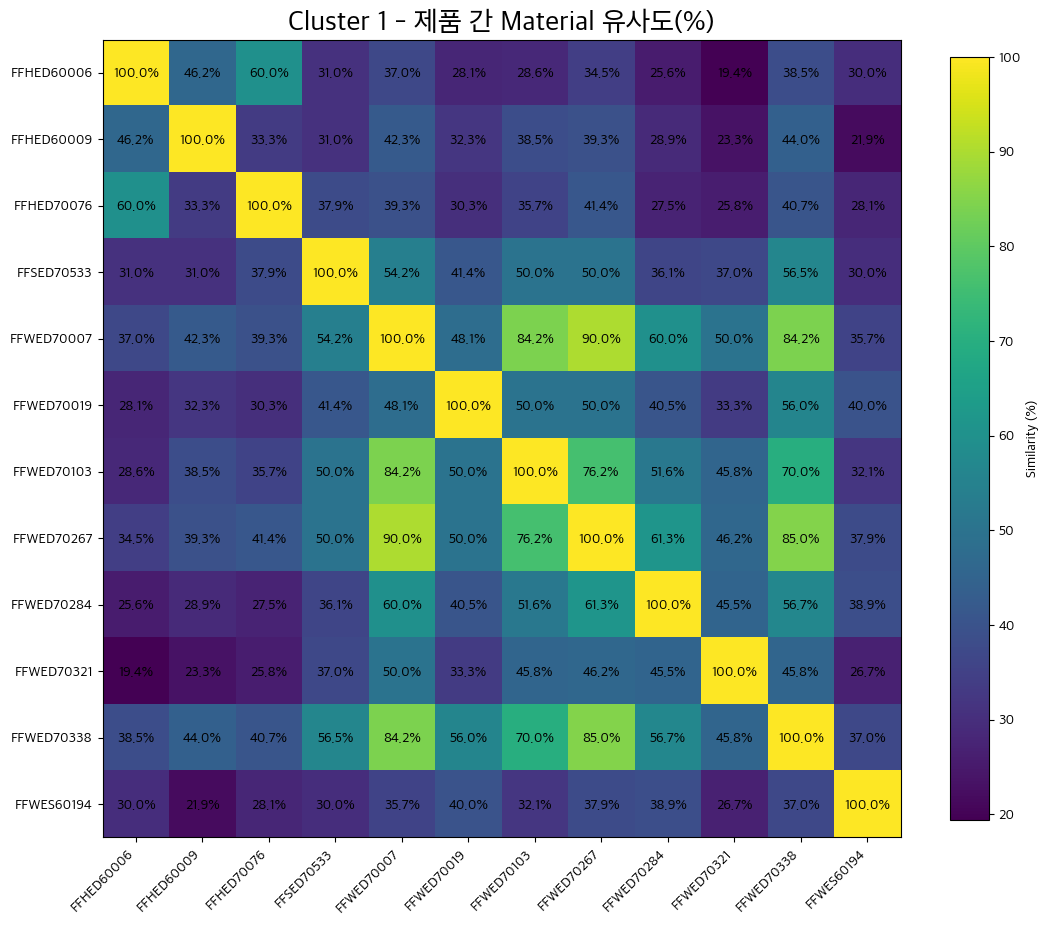

In [33]:
### 각 클러스터에 있는 제품코드별 자재코드를 기준으로 유사도 출력 
# Apply 
cluster = 1
cluster_1_df, cluster_1_sim_matrix = cluster_simillarity(fmb_df, p_type ,cluster) 
cluster_1_result = get_most_material(cluster_1_df) 
cluster_1_commons = get_full_commons(cluster_1_df) 

Cluster에 제외된 제품코드: 0


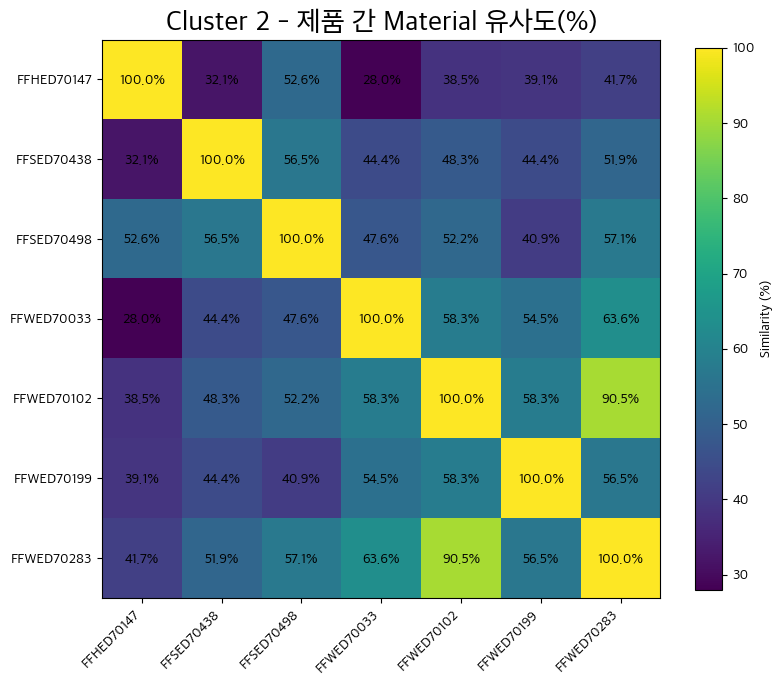

In [34]:
### 각 클러스터에 있는 제품코드별 자재코드를 기준으로 유사도 출력 
# Apply 
cluster = 2
cluster_2_df, cluster_2_sim_matrix = cluster_simillarity(fmb_df, p_type ,cluster)
cluster_2_result = get_most_material(cluster_2_df) 
cluster_2_commons = get_full_commons(cluster_2_df) 

Cluster에 제외된 제품코드: 0


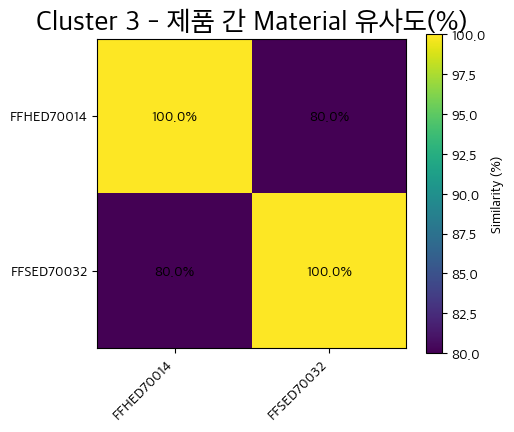

In [35]:
### 각 클러스터에 있는 제품코드별 자재코드를 기준으로 유사도 출력 
# Apply 
cluster = 3
cluster_3_df, cluster_3_sim_matrix = cluster_simillarity(fmb_df, p_type ,cluster)
cluster_3_result = get_most_material(cluster_3_df) 
cluster_3_commons = get_full_commons(cluster_3_df) 

In [37]:
### 각 클러스터별 공통 항목 자재코드 출력 
print('='*100)
print(f'Cluster 1: {cluster_1_commons}')
print('-'*100)
print(f'Cluster 2: {cluster_2_commons}')
print('-'*100)
print(f'Cluster 3: {cluster_3_commons}')
print('='*100)

Cluster 1: ['R3941-0024', 'R3951-0010', 'R3961-0057', 'R3968-0018']
----------------------------------------------------------------------------------------------------
Cluster 2: ['R3931-0028', 'R3941-0024', 'R3951-0010', 'R3961-0057', 'R3968-0002', 'R3968-0018']
----------------------------------------------------------------------------------------------------
Cluster 3: ['R3911-0231', 'R3931-0028', 'R3941-0024', 'R3951-0010', 'R3961-0057', 'R3961-0058', 'R3961-0059', 'R3961-0292', 'R3962-0002', 'R3963-0022', 'R3964-0013', 'R3964-0028', 'R3968-0002', 'R3968-0018', 'R3973-0005', 'R3973-0029']


In [140]:
### Get Cluster Column 
dataset = create_cluster_col(dataset)  

print('='*100)
print(f'Dataset Shape: {dataset.shape}')
print('='*100)

Dataset Shape: (101787, 40)


## ***TEMP MODELLING***
---

In [123]:
# Temp df 
temp_dataset = dataset[dataset['Cluster']==3].reset_index(drop=True)

# Print 
print('='*100)
print(f'Data Shape: {temp_dataset.shape}')
print('='*100)

Data Shape: (4214, 40)


In [121]:
### Target 
target_lst

['cycle time',
 'Ct 90_결과',
 'M/B 점도 (ML)_결과',
 'M/B 점도 (MS)_결과',
 'Scorch (T3)_결과',
 'Scorch (T5)_결과',
 'Vm (T3)_결과',
 'Vm (T5)_결과',
 '경도_결과']

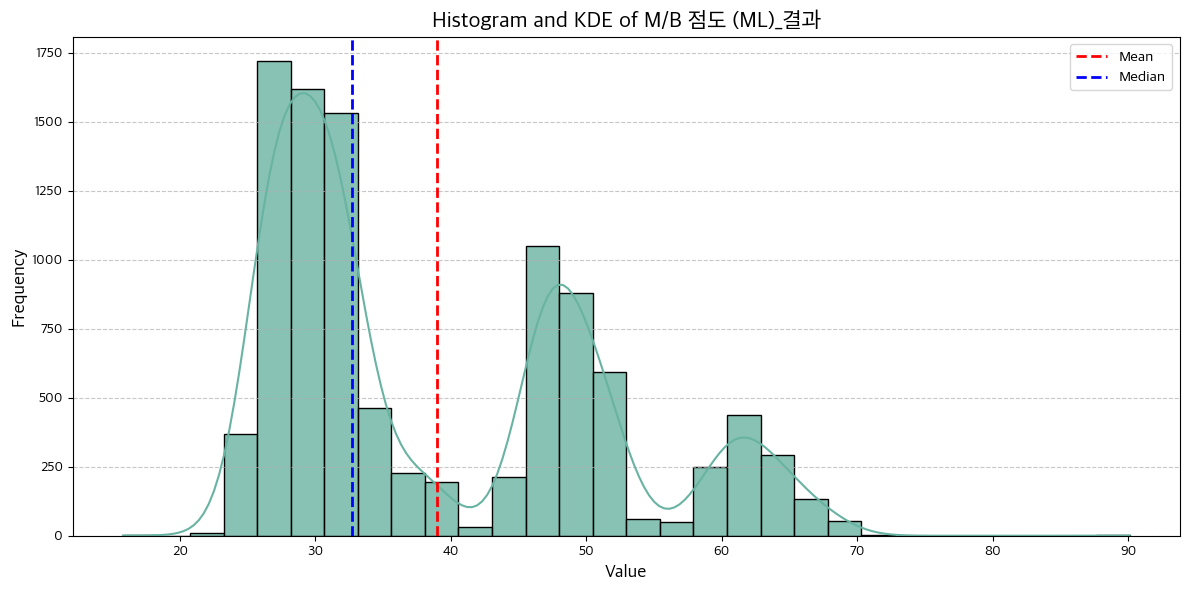

In [155]:
### Target 분포 확인
temp_col = 'M/B 점도 (ML)_결과'
target_dataset = temp_dataset.dropna(subset=[temp_col]) 

# 분포 Plot 
feature_normal_distribution(dataset, feature=temp_col)

In [106]:
### Train Test Split 
# Targets 
targets = ['cycle time','Ct 90_결과','Scorch (T3)_결과','Vm (T3)_결과','경도_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset, cycle_scaler, cycle_scaler_cols = create_train_test_dataset(temp_dataset, targets[0])

# CT90 
ct_train_dataset, ct_test_dataset, ct_scaler, ct_scaler_cols = create_train_test_dataset(temp_dataset, targets[1])

# Scorch 
sc_train_dataset, sc_test_dataset, sc_scaler, sc_scaler_cols = create_train_test_dataset(temp_dataset, targets[2])

# Vm 
vm_train_dataset, vm_test_dataset, vm_scaler, vm_scaler_cols = create_train_test_dataset(temp_dataset, targets[3])

# Hard 
hard_train_dataset, hard_test_dataset, hard_scaler, hard_scaler_cols = create_train_test_dataset(temp_dataset, targets[4])

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'Ct 90_결과':<20} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print(f"{'Scorch (T3)_결과':<20} | {len(sc_train_dataset):>14,} | {len(sc_test_dataset):>13,}")
print(f"{'Vm (T3)_결과':<20} | {len(vm_train_dataset):>14,} | {len(vm_test_dataset):>13,}")
print(f"{'경도_결과':<19} | {len(hard_train_dataset):>14,} | {len(hard_test_dataset):>13,}") 
print("="*100) 

cycle time            |         48,173 |        11,300
Ct 90_결과             |         24,904 |         5,842
Scorch (T3)_결과       |            297 |            70
Vm (T3)_결과           |         10,623 |         2,492
경도_결과               |         37,015 |         8,683
